In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sqlalchemy import create_engine, text
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [5]:
pd.set_option('display.max_columns', None)

In [58]:
accidents = pd.read_csv('../data/traffic_accidents.csv')

C:\Users\MattM\AppData\Local\Temp\ipykernel_424\1812331200.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv('../data/traffic_accidents.csv')


In [60]:
accidents.dtypes

shape                             object
object_id                          int64
incident_id                        int64
offense_id                         int64
offense_code                       int64
offense_code_extension             int64
top_traffic_accident_offense      object
first_occurrence_date             object
last_occurrence_date              object
reported_date                     object
incident_address                  object
geo_x                            float64
geo_y                            float64
geo_lon                          float64
geo_lat                          float64
district_id                       object
precinct_id                      float64
neighborhood_id                   object
bicycle_ind                      float64
pedestrian_ind                   float64
HARMFUL_EVENT_SEQ_1               object
HARMFUL_EVENT_SEQ_2               object
HARMFUL_EVENT_SEQ_MOST            object
road_location                     object
ROAD_DESCRIPTION

In [7]:
accidents['first_occurrence_date'].min()

'2013-01-01 00:00:00'

In [8]:
accidents['first_occurrence_date'].max()

'2024-06-03 15:54:00'

### Data from 1-1-2013 to 6-3-2024

In [9]:
accidents['top_traffic_accident_offense'].value_counts()

top_traffic_accident_offense
TRAF - ACCIDENT                   163258
TRAF - ACCIDENT - HIT & RUN        72460
TRAF - ACCIDENT - DUI/DUID          6790
TRAF - ACCIDENT - SBI               3926
TRAF - ACCIDENT - POLICE            2438
TRAF - ACCIDENT - FATAL              685
Name: count, dtype: int64

In [10]:
accidents['road_location'].value_counts()

road_location
ON ROADWAY                                           173261
On Roadway                                            38047
ON PRIVATE PROPERTY                                   15595
                                                       5861
RAN OFF RIGHT SIDE                                     4264
On Private Property                                    4223
RAN OFF LEFT SIDE                                      2371
Ran Off Right Side                                     1341
UNDER INVESTIGATION                                     876
Ran Off Left Side                                       544
VEHICLE CROSSED CENTER MEDIAN INTO OPPOSING LANES       425
RAN OFF 'T' INTERSECTION                                268
Center Median/Island                                    221
Vehicle Crossed Center Median Into Opposing Lanes        92
Ran Off 'T' Intersection                                 74
Name: count, dtype: int64

In [11]:
accidents['LIGHT_CONDITION'].value_counts()

LIGHT_CONDITION
DAY LIGHT              138562
DARK-LIGHTED            44846
Daylight                31789
Dark-Lighted            11563
DAWN OR DUSK             8289
                         6002
DARK-UNLIGHTED           4346
Dawn or Dusk             1608
Dark-Unlighted           1311
UNDER INVESTIGATION       876
Name: count, dtype: int64

In [18]:
accidents.head(2)

,shape,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,geo_x,geo_y,geo_lon,geo_lat,district_id,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,HARMFUL_EVENT_SEQ_MOST,road_location,ROAD_DESCRIPTION,ROAD_CONTOUR,ROAD_CONDITION,LIGHT_CONDITION,TU1_VEHICLE_TYPE,TU1_TRAVEL_DIRECTION,TU1_VEHICLE_MOVEMENT,TU1_DRIVER_ACTION,TU1_DRIVER_HUMANCONTRIBFACTOR,TU1_PEDESTRIAN_ACTION,TU2_VEHICLE_TYPE,TU2_TRAVEL_DIRECTION,TU2_VEHICLE_MOVEMENT,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y
0,<geoprocessing describe geometry object object...,38432,2016562933,201656293354410,5441,0,TRAF - ACCIDENT,2016-09-02 20:20:00,NaT,2016-09-02 20:23:00.000001,5200 BLOCK W YALE AVE,3125667.0,1668402.0,-105.053598,39.667713,4,423.0,Bear Valley,0.0,0.0,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,ON ROADWAY,INTERSECTION RELATED,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,PASSENGER CAR/VAN,EAST,GOING STRAIGHT,17,DISTRACTED CELLPHONE,OTHER,PASSENGER CAR/VAN,EAST,STOPPED IN TRAFFIC,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,NaN,NaN
1,<geoprocessing describe geometry object object...,38433,2016375907,201637590754410,5441,0,TRAF - ACCIDENT,2016-06-15 15:35:00,NaT,2016-06-15 15:35:00.000000,W 6TH AVE / N BRYANT ST,3135388.0,1689436.0,-105.018671,39.725320,1,122.0,Sun Valley,0.0,0.0,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,FRONT TO REAR WITH MV IN TRANSPORT,SIDE TO SIDE SAME DIRECTION WITH MV IN TRANSPORT,ON ROADWAY,HIGHWAY INTERCHANGE,STRAIGHT ON-GRADE,DRY,DAY LIGHT,PASSENGER CAR/VAN,EAST,CHANGING LANES,FAILED TO YIELD ROW,NO APPARENT,,SUV,EAST,GOING STRAIGHT,OTHER,NO APPARENT,,0.0,0.0,,,,,NaN,NaN


In [17]:
accidents['first_occurrence_date'] = pd.to_datetime(accidents['first_occurrence_date'], format='ISO8601')
accidents['last_occurrence_date'] = pd.to_datetime(accidents['last_occurrence_date'], format='ISO8601')
accidents['reported_date'] = pd.to_datetime(accidents['reported_date'], format='ISO8601')
accidents['month'] = accidents['reported_date'].dt.month
accidents['month_name'] = accidents['reported_date'].dt.month_name()
accidents['year'] = accidents['reported_date'].dt.year

In [19]:
accidents.shape

(249557, 48)

In [27]:
accidents['reported_date'].describe

<bound method NDFrame.describe of 0        2016-09-02 20:23:00.000001
1        2016-06-15 15:35:00.000000
2        2016-09-04 12:48:00.000000
3        2016-12-03 16:09:00.000001
4        2016-09-12 11:41:00.000000
                    ...            
249552   2016-11-18 08:15:00.000000
249553   2016-09-24 13:14:00.000000
249554   2016-09-09 08:18:00.000000
249555   2016-01-20 19:08:00.000000
249556   2016-06-23 12:11:00.000001
Name: reported_date, Length: 249557, dtype: datetime64[ns]>

In [45]:
accidents['month'] = accidents['reported_date'].dt.month
accidents['month_name'] = accidents['reported_date'].dt.month_name()
accidents['year'] = accidents['reported_date'].dt.year

In [52]:
over_time = accidents.groupby('year').agg({'offense_id' : 'nunique'}).reset_index()

In [53]:
over_time

,year,offense_id
0,2013,21617
1,2014,23109
2,2015,24796
3,2016,25434
4,2017,25900
5,2018,25577
6,2019,24881
7,2020,15930
8,2021,18465
9,2022,18081


In [54]:
accidents['offense_id'].nunique()

249550

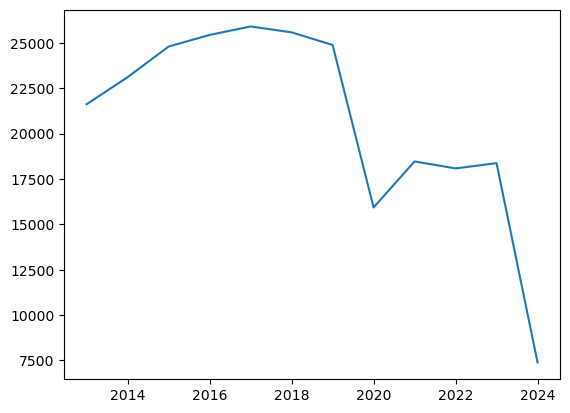

In [55]:
plt.plot(over_time['year'], over_time['offense_id'])

In [56]:
accidents.to_csv('../data/accidents_clean.csv')